In [91]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import torch
import torch.nn as nn
import torch.nn.functional as F
# 设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

/kaggle/input/chinese-couplets/couplet/vocabs
/kaggle/input/chinese-couplets/couplet/test/out.txt
/kaggle/input/chinese-couplets/couplet/test/in.txt
/kaggle/input/chinese-couplets/couplet/test/.in.txt.swp
/kaggle/input/chinese-couplets/couplet/test/.out.txt.swp
/kaggle/input/chinese-couplets/couplet/train/out.txt
/kaggle/input/chinese-couplets/couplet/train/in.txt
cuda


In [92]:
# 读取文件，每行以空格分隔
def load_lines(filename='vocabs'):
    with open(f'/kaggle/input/chinese-couplets/couplet/{filename}', 'r') as f:
        lines = []
        line = f.readline()
        while line:
            words = line.strip().split(' ')
            lines.append(words)
            line = f.readline()
    print(filename, len(lines))
    return lines

from torch.utils.data import DataLoader
# 词汇表
all_tokens = [i[0] for i in load_lines()]
vocabs = {token: index for index, token in enumerate(all_tokens)}

BOS = 0
EOS = 1
batch_size = 32
MAX_LENGTH = 10
train_data_size = batch_size * 100

def collate(batch):
    enc_input = []
    dec_output = []
    for x, y in batch:
        enc_input.append(torch.tensor(x, device=device))
        dec_output.append(torch.tensor(y, device=device))
    enc_input = torch.nn.utils.rnn.pad_sequence(enc_input, batch_first=True)
    dec_output = torch.nn.utils.rnn.pad_sequence(dec_output, batch_first=True)
    return enc_input, dec_output
    

# 训练集
data = [([*(vocabs.get(i) for i in x), EOS], [BOS, *(vocabs.get(j) for j in y), EOS]) for x, y in zip(
    load_lines('train/in.txt')[:train_data_size], load_lines('train/out.txt')[:train_data_size]
)]
print(data[-1])
dl = DataLoader(data, batch_size=batch_size, shuffle=True, collate_fn=collate)
# 测试集
test_data = [([*(vocabs.get(i) for i in x), EOS], [BOS, *(vocabs.get(j) for j in y), EOS]) for x, y in zip(
    load_lines('test/in.txt'), load_lines('test/out.txt')
)]
print(test_data[-1])
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate)


vocabs 9130
train/in.txt 770491
train/out.txt 770491
([276, 25, 34, 420, 948, 3, 401, 1776, 401, 661, 3, 16, 782, 16, 1668, 1], [0, 121, 45, 159, 642, 448, 3, 205, 73, 205, 91, 3, 18, 1600, 18, 22, 1])
test/in.txt 4000
test/out.txt 4000
([21, 380, 463, 11, 3, 309, 2643, 446, 40, 46, 44, 630, 1], [0, 14, 600, 869, 244, 3, 524, 494, 1337, 54, 188, 588, 401, 1])


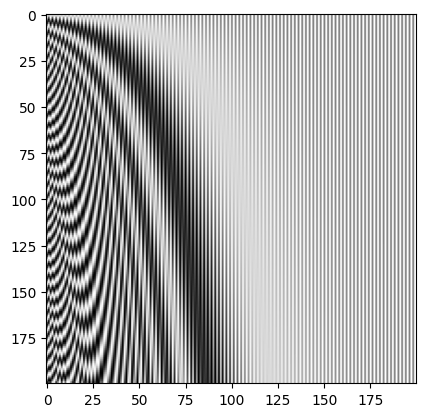

torch.Size([80, 100, 200])
torch.Size([80, 100, 200])


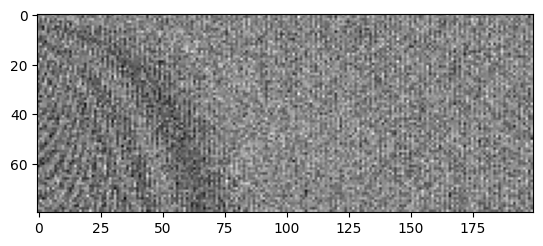

In [93]:
import math
import matplotlib.pyplot as plt


def get_pos_embedding(maxlen, embedding_size):
    theta = torch.exp(-torch.arange(0, embedding_size, 2)
                      * math.log(10000) / embedding_size)
    pos = torch.arange(0, maxlen).reshape(maxlen, 1)
    pos_embedding = torch.zeros((maxlen, embedding_size))
    pos_embedding[:, 0::2] = torch.sin(pos * theta)
    pos_embedding[:, 1::2] = torch.cos(pos * theta)
    plt.imshow(pos_embedding[:embedding_size], cmap='gray')
    plt.show()
    return pos_embedding.unsqueeze(1)


class PositionEncoding(nn.Module):
    def __init__(self, embedding_size, dropout, maxlen=1000):
        super().__init__()
        pos_embdding = get_pos_embedding(maxlen, embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embdding)

    def forward(self, token_embdding):
        seq_len = token_embdding.size(0)  # token长度
        token_embdding = token_embdding + self.pos_embedding[:seq_len, :]
        return self.dropout(token_embdding)


embedding_size = 200
num_embedding = 1000
batch_size = 100
seq_len = 80
ps = PositionEncoding(embedding_size, 0)
test_emb = nn.Embedding(num_embedding, embedding_size)
test_input = torch.randint(0, num_embedding, (seq_len, batch_size))
out: torch.Tensor = test_emb(test_input)
print(out.shape)
out = ps(out)
print(out.shape)
plt.imshow(out[:, 0].detach().numpy(), cmap='gray')
plt.show()


In [94]:

def mask_fill(mt):
    return mt.masked_fill(mt == 1, float(0.)).masked_fill(mt == 0, float('-inf'))

def create_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

    

sz = 4
mt = torch.ones((sz, sz))
print(mt)
print(mask_fill(mt.triu()))
mt = mask_fill(mt.tril())
print(torch.softmax(mt, dim=0))
print(mt)
print(create_mask(3))
torch.softmax(mt+torch.randn((sz, sz)), dim=0)


tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[0., 0., 0., 0.],
        [-inf, 0., 0., 0.],
        [-inf, -inf, 0., 0.],
        [-inf, -inf, -inf, 0.]])
tensor([[0.2500, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.3333, 0.0000, 0.0000],
        [0.2500, 0.3333, 0.5000, 0.0000],
        [0.2500, 0.3333, 0.5000, 1.0000]])
tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])
tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.]], device='cuda:0')


tensor([[0.2096, 0.0000, 0.0000, 0.0000],
        [0.4924, 0.2497, 0.0000, 0.0000],
        [0.0481, 0.1977, 0.4487, 0.0000],
        [0.2499, 0.5526, 0.5513, 1.0000]])

In [95]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, d_model, nhead, num_enc_layers, num_dec_layers, dim_forward, dropout, enc_voc_size,dec_voc_size):
        super().__init__()
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_enc_layers, num_decoder_layers=num_dec_layers,
                                          dim_feedforward=dim_forward, dropout=dropout, batch_first=True)
        self.enc_emb = nn.Embedding(enc_voc_size, d_model)
        self.dec_emb = nn.Embedding(dec_voc_size, d_model)
        self.ff = nn.Linear(d_model, dec_voc_size)
        self.pos_encoding = PositionEncoding(d_model, dropout)
        
    def forward(self, enc_input, dec_input, tgt_mask, enc_pad_mask, dec_pad_mask):
        enc_emb = self.pos_encoding(self.enc_emb(enc_input))
        dec_emb = self.pos_encoding(self.dec_emb(dec_input))
        outs = self.transformer(src=enc_emb, tgt=dec_emb, tgt_mask=tgt_mask,
                         src_key_padding_mask=enc_pad_mask, 
                         tgt_key_padding_mask=dec_pad_mask)
        return self.ff(outs)
    
    def encode(self, enc_input):
        enc_emb = self.pos_encoding(self.enc_emb(enc_input))
        return self.transformer.encoder(enc_emb)
    
    def decode(self, dec_input, memory, dec_mask):
        dec_emb = self.pos_encoding(self.dec_emb(dec_input))
        out = self.transformer.decoder(dec_emb, memory, dec_mask)
        out = out.transpose(0, 1)
        return self.ff(out[:, -1])


In [96]:
import random
import time

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
    
def train_epoch(dataloader, model, optimizer, criterion):
    total_loss = 0
    for input_tensor, target_tensor in dataloader:
        optimizer.zero_grad()
        tgt_mask = create_mask(target_tensor.size(1))
        out = model(input_tensor, target_tensor, tgt_mask, input_tensor==0, target_tensor==0)
        # print(out.shape, target_tensor.shape)
        loss = criterion(
            out.view(-1, out.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [97]:
def train(train_dataloader, model, n_epochs, learning_rate=0.001,
               print_every=5, plot_every=5):
    start = time.time()
    plot_epoches = []
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, model, optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            plot_epoches.append(epoch)
            
    plt.scatter(plot_epoches, plot_losses)
    plt.show()

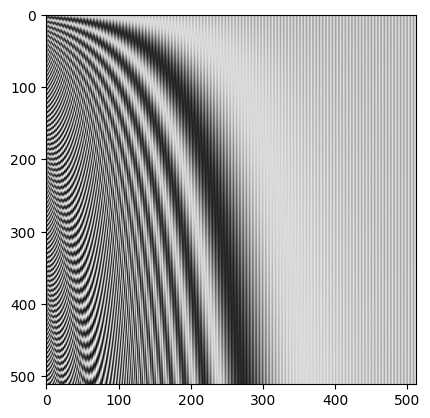

0m 32s (- 10m 8s) (5 5%) 3.5750
1m 4s (- 9m 37s) (10 10%) 3.4709
1m 36s (- 9m 6s) (15 15%) 3.4085
2m 8s (- 8m 35s) (20 20%) 3.4156
2m 41s (- 8m 3s) (25 25%) 3.3887
3m 13s (- 7m 31s) (30 30%) 3.3864
3m 45s (- 6m 58s) (35 35%) 3.3874
4m 17s (- 6m 26s) (40 40%) 3.3532
4m 49s (- 5m 54s) (45 45%) 3.3701
5m 21s (- 5m 21s) (50 50%) 3.3608
5m 53s (- 4m 49s) (55 55%) 3.3494
6m 25s (- 4m 17s) (60 60%) 3.3510
6m 57s (- 3m 44s) (65 65%) 3.3558
7m 29s (- 3m 12s) (70 70%) 3.3424
8m 1s (- 2m 40s) (75 75%) 3.3225
8m 33s (- 2m 8s) (80 80%) 3.3291
9m 5s (- 1m 36s) (85 85%) 3.3310
9m 37s (- 1m 4s) (90 90%) 3.3397
10m 9s (- 0m 32s) (95 95%) 3.3200
10m 41s (- 0m 0s) (100 100%) 3.3401


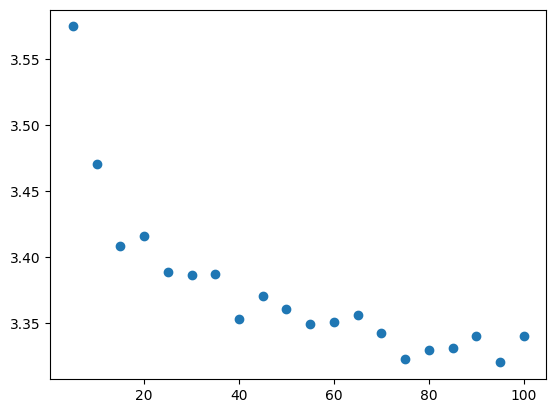

In [98]:
model = Seq2SeqTransformer(512, 8, 6, 6, 2048, 0.1, len(all_tokens), len(all_tokens)).to(device=device)
train(dl, model, 100)

In [99]:
def greedy_decode(model, src, start_symbol, end_symbol):
    src = src.to(device)
    batch_sz, seq_len = src.shape
    memory = model.encode(src)
    ys = torch.ones(batch_sz, 1).fill_(start_symbol).type(torch.long).to(device)
    print(seq_len)
    for i in range(seq_len + 3):
        memory = memory.to(device)
        tgt_mask = create_mask(ys.size(1))
        out = model.decode(ys, memory, tgt_mask)
        # print('out', out.shape)
        _, next_word = torch.max(out, dim=1)
        # print('next_word', next_word.shape)
        next_word = next_word[0].item()
        ys = torch.cat([ys, torch.ones(batch_sz, 1).type_as(src.data).fill_(next_word)], dim=1)
        # print('ys', ys.shape)
        if next_word == end_symbol:
            break
    return ys
# torch.ones(batch_sz, 1).type_as(src.data).fill_(next_word)
def translate(model, src_input):
    model.eval()
    tgt_tokens = greedy_decode(
        model, src, start_symbol=BOS, end_symbol=EOS)
    for tgt_tok in tgt_tokens:
        tgt_seq = "".join([all_tokens[token_id] for token_id in tgt_tok])
        print(tgt_seq)

i = 0
for src,tgt in test_dl:
    i = i + 1
    if i > 5: break
    print('>', ' '.join([all_tokens[j.item()] for j in src[0]]))
    print('=', ' '.join([all_tokens[j] for j in tgt[0]]))
    translate(model, src)

> 腾 飞 上 铁 ， 锐 意 改 革 谋 发 展 ， 勇 当 千 里 马 </s>
= <s> 和 谐 南 供 ， 安 全 送 电 保 畅 通 ， 争 做 领 头 羊 </s>
19
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
<s>一一一一一一一一一一一一一一一一一一一一一一
> 苦 盼 郎 归 ， 每 唤 登 临 ， 心 中 只 恨 东 山 矮 </s> <s> <s> <s> <s> <s> <s> <s> <s> <s